In [665]:
import os
import numpy as np
import matplotlib.pylab as plt
from PIL import Image
import collections
import PIL

%matplotlib inline

In [2]:
test_files = os.listdir("test_photos")

In [12]:
photos = []
for item in test_files:
    if item[-4:] == ".jpg":
        photos.append("test_photos/" + str(item))

test_photos/BROOCH_1012466.jpg


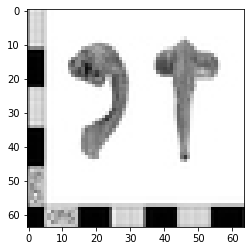

In [58]:
fname = photos[0]
print(fname)
image = Image.open(fname).convert("L")
arr = np.asarray(image)
plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.show()

In [231]:
t = np.asarray([['a','b','c'],[1,2,3]])
# columns in t.T
# rows in t
# 0 = black, 255 = white
def show_img(img_array):
    plt.imshow(img_array, cmap='gray', vmin=0, vmax=255)
    plt.show()

In [424]:
image1 = Image.open(photos[0]).convert("L")
image2 = Image.open(photos[2]).convert("L")
image3 = Image.open(photos[150]).convert("L")
image4 = Image.open(photos[211]).convert("L")
image5 = Image.open(photos[218]).convert("L")
image6 = Image.open("test_photos/BROOCH_100835.jpg").convert("L")
image7 = Image.open("test_photos/BROOCH_100611.jpg").convert("L")
image8 = Image.open("test_photos/BROOCH_1002770.jpg").convert("L")
image9 = Image.open("test_photos/BROOCH_100769.jpg").convert("L")

In [832]:
def check_pure_background(array, wbound, bbound):
    cnt = collections.Counter()
    x = 0
    i = 0
    wns = 0
    bns = 0
    for row in array:
        for p in row:
            cnt[p]+=1
            if p <= int(bbound):
                bns +=1
            elif p >= int(wbound):
                wns +=1
    for item in cnt:
        if cnt[item] > 500:
            x+=1
            i = item
    if x == 1:
        #print("Pure background of: " + str(i))
        return([True, i])
    elif x > 1:
        return([True, i])
    else:
        #print("White: " + str(cnt[255]) + "  Black:  " + str(cnt[0]))
        #print("W-neighbors: " + str(wns) + "  B-neighbors: " + str(bns))
        return ([False, {'w': cnt[255], 'b': cnt[0], 'wns': wns, 'bns': bns}])

In [425]:
arr1 = np.asarray(image1)
arr2 = np.asarray(image2)
arr3 = np.asarray(image3)
arr4 = np.asarray(image4)
arr5 = np.asarray(image5)
arr6 = np.asarray(image6)
arr7 = np.asarray(image7)
arr8 = np.asarray(image8)
arr9 = np.asarray(image9)
arrs = [arr1, arr2, arr3, arr4, arr5, arr6, arr7, arr8, arr9]

In [819]:
white_bound = 250
black_bound = 30

In [820]:
def white_neighbors(p):
    new_p = []
    for row in p:
        new_row = []
        for pixel in row:
            if pixel >= white_bound:
                new_row.append(255)
            else:
                new_row.append(pixel)
        new_p.append(new_row)
    return(new_p)
def black_neighbors(p):
    new_p = []
    for row in p:
        new_row = []
        for pixel in row:
            if pixel <= black_bound:
                new_row.append(255)
            else:
                new_row.append(pixel)
        new_p.append(new_row)
    return(new_p)

In [821]:
# estimate whether or not this is an edge row of pixels
def eval_line(line):
    total_white = 0
    for pixel in line:
        if pixel >= white_bound:
            total_white +=1
    if total_white >= 40:
        return True
    else:
        return False
    
def eval_rows(p):
    outcomes = []
    for row in p:
        outcomes.append(eval_line(row))
    top = outcomes[0:3]
    bot = outcomes[-3:]
    if top.count(True) == bot.count(True):
        # go a bit further
        top = outcomes[0:5]
        bot = outcomes[-5:]
        if top.count(True) == bot.count(True):
            # unlikely that there's a horizontal bar
            return "None"
    elif top.count(False) == bot.count(False):
        # maybe a bar on both for some reason
        return "Both"
    elif top.count(False) > bot.count(False):
        # more likely bar on top
        return "Top"
    else:
        # more likely bar on bottom
        return "Bot"

def eval_cols(p):
    outcomes = []
    for col in p.T:
        outcomes.append(eval_line(col))
    left = outcomes[0:3]
    right = outcomes[-3:]
    if left.count(True) == right.count(True):
        # go a bit further
        left = outcomes[0:5]
        right = outcomes[-5:]
        if left.count(True) == right.count(True):
            # unlikely that there's a horizontal bar
            return "None"
    elif left.count(False) == right.count(False):
        # maybe a bar on both for some reason
        return "Both"
    elif left.count(False) > right.count(False):
        # more likely bar on top
        return "Left"
    else:
        # more likely bar on bottom
        return "Right"

In [822]:
# returns true if it finds a ruler signal
def check_ruler_signal(rows):
    base_num_white_pixels = 0
    for pixel in rows[0]:
        if pixel >= white_bound:
            base_num_white_pixels+=1
    tracker = 0
    for row in rows:
        white_pixels = 0
        for pixel in row:
            if pixel >= white_bound:
                white_pixels+=1
        if white_pixels <= (0.5 * base_num_white_pixels):
            return [True, tracker]
        tracker+=1
    return [False, tracker]

In [823]:
# when neither ends of an image have a ruler, check to see if one has a sneaky ruler
def check_sneaky_ruler(direction, p):
    if direction == "Horizontal":
        # jump to pixel row 50, see if its unbroken, check
        rows = []
        for row in p:
            rows.append(row)
        # we iterate from row 51 to 64, where a drop in white is a ruler --> making 20 because of data behavior
        bottom_rows = rows[-20:]
        # we iterate from row 8 to 0, where a drop in white is a ruler
        top_rows = rows[0:8]
        top_rows.reverse()
        b_ruler, b_loc = check_ruler_signal(bottom_rows)
        #if b_ruler:
            #print("Sneaky ruler found " + str(abs(b_loc - 15)) + " rows above bottom")
        t_ruler, t_loc = check_ruler_signal(top_rows)
        #if t_ruler:
            #print("Sneaky ruler found " + str(abs(t_loc - 15)) + " rows below top")
        return({"Bot": [b_ruler, 64 - abs(b_loc-20)], "Top": [t_ruler, abs(t_loc-8)]})
        
    # we don't go as far for vertical because they tend to be thinner due to squishing psychhhh
    elif direction == "Vertical":
        cols = []
        for col in p.T:
            cols.append(col)
        right_cols = cols[-8:]
        left_cols = cols[0:8]
        left_cols.reverse()
        r_ruler, r_loc = check_ruler_signal(right_cols)
        #if r_ruler:
            #print("Sneaky ruler found " + str(abs(r_loc - 10)) + " cols from the right")
        l_ruler, l_loc = check_ruler_signal(left_cols)
        #if l_ruler:
            #print("Sneaky ruler found " + str(abs(l_loc - 10)) + " cols from the left")
        return({"Right": [r_ruler, 64 - abs(r_loc-10)], "Left": [l_ruler, abs(l_loc-10)]})


In [824]:
# 45 white neighbors
def check_simple_ruler(where, p):
    rows = []
    for row in p:
        rows.append(row)
        
    if where == "Top" or where == "Left":
        tracker = 0
        for row in rows:
            wns = 0
            for pixel in row:
                if pixel >= white_bound:
                    wns+=1
            if wns >= 45:
                return tracker
            else:
                tracker+=1
                if tracker == 40:
                    return (0)
                   # if where == "Top":
                    #    return (10)
                    #else:
                      #  return (5)
    elif where == "Bot" or where == "Right":
        rows.reverse()
        tracker = 0
        for row in rows:
            wns = 0
            for pixel in row:
                if pixel >= white_bound:
                    wns+=1
            if wns >= 45:
                return (64 - tracker)
            else:
                tracker+=1
                if tracker == 40:
                   # if where == "Bot":
                   #     return (54)
                   # else:
                   #     return (59)
                    return(0)

In [825]:
# if we are keeping a photo, get rid of the measurement bars
def calculate_crop_points(p):
    x_crops = {"Bot": 64, "Top": 0}
    y_crops = {"Right": 64, "Left": 0}
    
    # check rows and columns for close to unbroken lines
    x_guess = eval_rows(p)
    y_guess = eval_cols(p)
    
    # check for sneaky rulers
    if str(x_guess) == "None" or str(x_guess) == "Both" or x_guess == None:
        result = check_sneaky_ruler('Horizontal', p)
        if result["Bot"][0] == True:
            x_crops["Bot"] = int(result["Bot"][1])
        if result["Top"][0] == True:
            x_crops["Top"] = int(result["Top"][1])
    else:
        # handle simple rulers (e.g. Top, Bot, Right, Left)
        old = x_crops[x_guess]
        x_crops[x_guess] = check_simple_ruler(str(x_guess), p)
        if x_crops[x_guess] == old:
            result = check_sneaky_ruler('Horizontal', p)
            if result["Bot"][0] == True:
                x_crops["Bot"] = int(result["Bot"][1])
            if result["Top"][0] == True:
                x_crops["Top"] = int(result["Top"][1])
        #print(check_simple_ruler(str(x_guess), p))
              
    if str(y_guess) == "None" or str(y_guess) == "Both" or y_guess == None:
        result = check_sneaky_ruler('Vertical', p)
        if result["Right"][0] == True:
            y_crops["Right"] = int(result["Right"][1])
        if result["Left"][0] == True:
            y_crops["Left"] = int(result["Left"][1])
    else:
        # handle simple rulers (e.g. Top, Bot, Right, Left)
        old = y_crops[y_guess]
        y_crops[y_guess] = check_simple_ruler(str(y_guess), p.T)
        if y_crops[y_guess] == old:
            result = check_sneaky_ruler('Vertical', p)
            if result["Right"][0] == True:
                y_crops["Right"] = int(result["Right"][1])
            if result["Left"][0] == True:
                y_crops["Left"] = int(result["Left"][1])
        #print(check_simple_ruler(str(y_guess), p.T))
    
    #print(str(x_guess) + " & " + str(y_guess))
    #print(x_crops)
    #print(y_crops)
    return (x_crops, y_crops)

In [826]:
def whiteline():
    out = []
    for i in range(64):
        out.append(255)
    return(out)

def crop(xs, ys, p):
    new_rows = []
    dont_touch_rows = [0,64]
    if xs["Bot"] == 0 and xs["Top"] == 0:
        # adding because of data behavior
        dont_touch_rows[1] = 58
    else:
        if xs["Bot"] != 64:
            dont_touch_rows[1] = xs["Bot"]
        if xs["Top"] != 0:
            dont_touch_rows[0] = xs["Top"]
    for i in range(64):
        if i >= dont_touch_rows[0] and i < dont_touch_rows[1]:
            new_rows.append(p[i])
        else:
            new_rows.append(whiteline())
    row_cleaned_p = np.array(new_rows)
    new_p = row_cleaned_p.T
    
    new_cols = []
    dont_touch_cols = [0,64]
    
    if ys["Right"] == 0 and ys["Left"] == 0:
        # adding because of data behavior
        dont_touch_cols[0] = 6
        dont_touch_cols[1] = 58
    else:
        if ys["Right"] != 64:
            dont_touch_cols[1] = ys["Right"]
        if ys["Left"] != 0:
            dont_touch_cols[0] = ys["Left"]
    for i in range(64):
        if i >= dont_touch_cols[0] and i < dont_touch_cols[1]:
            new_cols.append(new_p[i])
        else:
            new_cols.append(whiteline())
    final_p = np.array(new_cols)
    return(final_p.T)

In [827]:
# 'photos' must be list of numpy arrays
def fix_photos(ids_and_photos, inline):
    discarded = 0
    fixed = 0
    problems = []
    outlist = []
    for ID, p in ids_and_photos:
        try:
            # --------- first, get rid of photo if it doesn't have a pure-ish background -----------------
            v, stats = check_pure_background(p, white_bound, black_bound)
            exclude = 0
            if v == False:
                # check if there are tons of neighbors
                total_whites = stats['w'] + stats['wns']
                total_blacks = stats['b'] + stats['bns']
                # if we have a close to pure white background, turn all neighbors into pure white (255)
                if total_whites >= 500:
                    p = np.asarray(white_neighbors(p))
                # if close to black, turn to white
                if total_blacks >= 500:
                    p = np.asarray(black_neighbors(p))
                # if not pure background, exclude photo
                if total_whites < 500 and total_blacks < 500:
                    exclude = 1
            if v == True:
                mode = 0
                if stats <= black_bound:
                    # turn all pixels <= black_bound to white
                    p = np.asarray(black_neighbors(p))
                else:
                    # turn all pixels >= white_bound to white
                    p = np.asarray(white_neighbors(p))
                
            if exclude == 0:
                x_crop, y_crop = calculate_crop_points(p)
                #print(calculate_crop_points(p))
                new_photo = crop(x_crop, y_crop, p)
                if inline == True:
                    show_img(new_photo)
                outlist.append([ID, new_photo])
                fixed+=1
                #show_img(new_photo)
            else:
                discarded+=1
                print("Discarded: " + str(discarded))
            exclude = 0
            # -------------------------------------------------------------------------------------------
        except:
            problems.append(ID)
    print("Problems : -------------")
    print(len(problems))
    print(problems)
    print("Discarded : ------------")
    print(discarded)
    print("Fixed : ----------------")
    print(fixed)
    return(outlist)

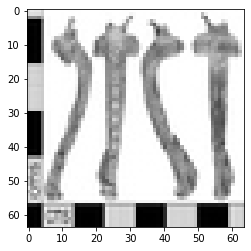

Pure background of: 255
({'Bot': 0, 'Top': 0}, {'Right': 64, 'Left': 5})


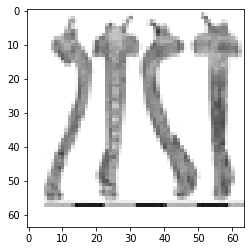

Problems : -------------
0
[]
Discarded : ------------
0
Fixed : ----------------
1


In [804]:
p = Image.open("test_photos/BROOCH_1000043.jpg").convert("L")
show_img(p)
x = fix_photos([["ID", np.asarray(p)]], False)

In [818]:
A = []
for i in range(1024):
    p = Image.open(photos[i]).convert("L")
    A.append([photos[i], np.asarray(p)])
fixed_photos = fix_photos(A, False)
for fp in fixed_photos:
    plt.imsave("test_photos/USE_" + str(fp[0][12:]), fp[1], cmap="gray")

Pure background of: 255
({'Bot': 57, 'Top': 0}, {'Right': 64, 'Left': 6})
Pure background of: 255
({'Bot': 64, 'Top': 0}, {'Right': 59, 'Left': 0})
Pure background of: 255
({'Bot': 55, 'Top': 0}, {'Right': 64, 'Left': 5})
Pure background of: 255
({'Bot': 56, 'Top': 0}, {'Right': 64, 'Left': 5})
Pure background of: 255
({'Bot': 64, 'Top': 0}, {'Right': 64, 'Left': 0})
Pure background of: 255
({'Bot': 54, 'Top': 0}, {'Right': 64, 'Left': 4})
Pure background of: 252
({'Bot': 64, 'Top': 0}, {'Right': 64, 'Left': 0})
Pure background of: 255
({'Bot': 54, 'Top': 0}, {'Right': 64, 'Left': 0})
Pure background of: 255
({'Bot': 54, 'Top': 0}, {'Right': 64, 'Left': 5})
Pure background of: 255
({'Bot': 64, 'Top': 9}, {'Right': 64, 'Left': 7})
Pure background of: 255
({'Bot': 56, 'Top': 0}, {'Right': 64, 'Left': 4})
Pure background of: 255
({'Bot': 58, 'Top': 0}, {'Right': 64, 'Left': 5})
Pure background of: 255
({'Bot': 56, 'Top': 0}, {'Right': 64, 'Left': 8})
Pure background of: 255
({'Bot': 57, '

Pure background of: 255
({'Bot': 64, 'Top': 0}, {'Right': 57, 'Left': 0})
Pure background of: 255
({'Bot': 54, 'Top': 0}, {'Right': 64, 'Left': 0})
Pure background of: 255
({'Bot': 56, 'Top': 0}, {'Right': 64, 'Left': 4})
Pure background of: 255
({'Bot': 64, 'Top': 0}, {'Right': 64, 'Left': 4})
Pure background of: 255
({'Bot': 58, 'Top': 0}, {'Right': 64, 'Left': 4})
Pure background of: 255
({'Bot': 56, 'Top': 0}, {'Right': 64, 'Left': 8})
Pure background of: 255
({'Bot': 57, 'Top': 0}, {'Right': 64, 'Left': 5})
Pure background of: 255
({'Bot': 54, 'Top': 0}, {'Right': 64, 'Left': 0})
Pure background of: 255
({'Bot': 56, 'Top': 0}, {'Right': 64, 'Left': 6})
Pure background of: 255
({'Bot': 64, 'Top': 0}, {'Right': 64, 'Left': 5})
Pure background of: 255
({'Bot': 56, 'Top': 0}, {'Right': 64, 'Left': 8})
({'Bot': 58, 'Top': 0}, {'Right': 64, 'Left': 4})
Pure background of: 255
({'Bot': 64, 'Top': 0}, {'Right': 55, 'Left': 0})
Pure background of: 255
({'Bot': 55, 'Top': 0}, {'Right': 64, 

({'Bot': 55, 'Top': 0}, {'Right': 64, 'Left': 0})
Discarded: 12
Pure background of: 255
({'Bot': 54, 'Top': 0}, {'Right': 64, 'Left': 6})
Pure background of: 255
({'Bot': 57, 'Top': 0}, {'Right': 64, 'Left': 4})
Pure background of: 255
({'Bot': 52, 'Top': 0}, {'Right': 64, 'Left': 0})
({'Bot': 58, 'Top': 0}, {'Right': 64, 'Left': 0})
Pure background of: 255
({'Bot': 55, 'Top': 0}, {'Right': 64, 'Left': 0})
Pure background of: 255
({'Bot': 55, 'Top': 0}, {'Right': 64, 'Left': 4})
Pure background of: 255
({'Bot': 58, 'Top': 0}, {'Right': 64, 'Left': 6})
Pure background of: 255
({'Bot': 55, 'Top': 0}, {'Right': 64, 'Left': 7})
Pure background of: 255
({'Bot': 56, 'Top': 0}, {'Right': 64, 'Left': 3})
Pure background of: 255
({'Bot': 55, 'Top': 0}, {'Right': 64, 'Left': 9})
Pure background of: 255
({'Bot': 58, 'Top': 0}, {'Right': 64, 'Left': 5})
Pure background of: 255
({'Bot': 57, 'Top': 0}, {'Right': 64, 'Left': 9})
Pure background of: 255
({'Bot': 60, 'Top': 0}, {'Right': 64, 'Left': 3}

Pure background of: 255
({'Bot': 55, 'Top': 0}, {'Right': 64, 'Left': 0})
Pure background of: 255
({'Bot': 52, 'Top': 0}, {'Right': 64, 'Left': 6})
Pure background of: 255
({'Bot': 64, 'Top': 0}, {'Right': 64, 'Left': 5})
Pure background of: 255
({'Bot': 52, 'Top': 0}, {'Right': 64, 'Left': 0})
Pure background of: 255
({'Bot': 56, 'Top': 0}, {'Right': 64, 'Left': 4})
Pure background of: 255
({'Bot': 60, 'Top': 0}, {'Right': 64, 'Left': 3})
Pure background of: 255
({'Bot': 55, 'Top': 0}, {'Right': 64, 'Left': 0})
Pure background of: 255
({'Bot': 57, 'Top': 0}, {'Right': 64, 'Left': 10})
Pure background of: 255
({'Bot': 50, 'Top': 0}, {'Right': 64, 'Left': 11})
Pure background of: 255
({'Bot': 50, 'Top': 0}, {'Right': 64, 'Left': 9})
Pure background of: 255
({'Bot': 57, 'Top': 0}, {'Right': 64, 'Left': 10})
Pure background of: 255
({'Bot': 59, 'Top': 0}, {'Right': 64, 'Left': 0})
Pure background of: 255
({'Bot': 53, 'Top': 0}, {'Right': 64, 'Left': 7})
Pure background of: 255
({'Bot': 59

({'Bot': 64, 'Top': 7}, {'Right': 64, 'Left': 3})
Pure background of: 255
({'Bot': 49, 'Top': 0}, {'Right': 64, 'Left': 0})
Pure background of: 255
({'Bot': 59, 'Top': 0}, {'Right': 64, 'Left': 0})
({'Bot': 64, 'Top': 0}, {'Right': 55, 'Left': 7})
Pure background of: 255
({'Bot': 60, 'Top': 0}, {'Right': 64, 'Left': 2})
Pure background of: 255
({'Bot': 0, 'Top': 0}, {'Right': 64, 'Left': 4})
Pure background of: 255
({'Bot': 52, 'Top': 0}, {'Right': 64, 'Left': 0})
Pure background of: 255
({'Bot': 54, 'Top': 0}, {'Right': 64, 'Left': 0})
Pure background of: 255
({'Bot': 46, 'Top': 0}, {'Right': 64, 'Left': 0})
Pure background of: 255
({'Bot': 64, 'Top': 5}, {'Right': 64, 'Left': 5})
Pure background of: 255
({'Bot': 60, 'Top': 0}, {'Right': 64, 'Left': 6})
Pure background of: 254
({'Bot': 64, 'Top': 0}, {'Right': 64, 'Left': 5})
Pure background of: 255
({'Bot': 52, 'Top': 0}, {'Right': 64, 'Left': 6})
Pure background of: 255
({'Bot': 57, 'Top': 0}, {'Right': 64, 'Left': 4})
Pure backgrou

({'Bot': 59, 'Top': 0}, {'Right': 64, 'Left': 3})
Pure background of: 255
({'Bot': 56, 'Top': 0}, {'Right': 64, 'Left': 3})
Pure background of: 255
({'Bot': 56, 'Top': 0}, {'Right': 64, 'Left': 0})
Pure background of: 255
({'Bot': 58, 'Top': 0}, {'Right': 64, 'Left': 6})
Pure background of: 255
({'Bot': 55, 'Top': 0}, {'Right': 64, 'Left': 6})
Pure background of: 255
({'Bot': 51, 'Top': 0}, {'Right': 64, 'Left': 0})
Pure background of: 255
({'Bot': 57, 'Top': 0}, {'Right': 64, 'Left': 5})
Pure background of: 255
({'Bot': 48, 'Top': 0}, {'Right': 64, 'Left': 8})
Pure background of: 255
({'Bot': 48, 'Top': 0}, {'Right': 64, 'Left': 6})
Pure background of: 255
({'Bot': 64, 'Top': 0}, {'Right': 64, 'Left': 8})
Pure background of: 255
({'Bot': 64, 'Top': 8}, {'Right': 64, 'Left': 4})
Pure background of: 255
({'Bot': 64, 'Top': 7}, {'Right': 64, 'Left': 9})
Pure background of: 255
({'Bot': 56, 'Top': 0}, {'Right': 64, 'Left': 0})
Pure background of: 255
({'Bot': 51, 'Top': 0}, {'Right': 64, 

Pure background of: 255
({'Bot': 64, 'Top': 0}, {'Right': 64, 'Left': 7})
Pure background of: 255
({'Bot': 53, 'Top': 0}, {'Right': 57, 'Left': 0})
Pure background of: 255
({'Bot': 51, 'Top': 0}, {'Right': 64, 'Left': 6})
Pure background of: 255
({'Bot': 55, 'Top': 0}, {'Right': 64, 'Left': 5})
Pure background of: 255
({'Bot': 53, 'Top': 0}, {'Right': 64, 'Left': 9})
Pure background of: 255
({'Bot': 59, 'Top': 0}, {'Right': 64, 'Left': 3})
Pure background of: 255
({'Bot': 60, 'Top': 0}, {'Right': 64, 'Left': 5})
Pure background of: 255
({'Bot': 60, 'Top': 0}, {'Right': 64, 'Left': 0})
Pure background of: 255
({'Bot': 56, 'Top': 0}, {'Right': 64, 'Left': 6})
Pure background of: 0
({'Bot': 64, 'Top': 0}, {'Right': 64, 'Left': 8})
({'Bot': 52, 'Top': 0}, {'Right': 64, 'Left': 8})
Pure background of: 255
({'Bot': 64, 'Top': 6}, {'Right': 64, 'Left': 3})
Discarded: 23
Pure background of: 255
({'Bot': 58, 'Top': 0}, {'Right': 64, 'Left': 4})
Pure background of: 255
({'Bot': 49, 'Top': 0}, {'

Pure background of: 255
({'Bot': 56, 'Top': 0}, {'Right': 64, 'Left': 6})
Pure background of: 255
({'Bot': 56, 'Top': 0}, {'Right': 64, 'Left': 9})
Pure background of: 255
({'Bot': 56, 'Top': 0}, {'Right': 64, 'Left': 5})
Pure background of: 255
({'Bot': 54, 'Top': 0}, {'Right': 64, 'Left': 0})
({'Bot': 56, 'Top': 0}, {'Right': 64, 'Left': 4})
Discarded: 28
Pure background of: 255
({'Bot': 55, 'Top': 0}, {'Right': 64, 'Left': 26})
Pure background of: 252
({'Bot': 64, 'Top': 0}, {'Right': 64, 'Left': 0})
Discarded: 29
Pure background of: 255
({'Bot': 50, 'Top': 0}, {'Right': 64, 'Left': 5})
({'Bot': 64, 'Top': 0}, {'Right': 64, 'Left': 0})
({'Bot': 54, 'Top': 0}, {'Right': 64, 'Left': 4})
Pure background of: 255
({'Bot': 57, 'Top': 0}, {'Right': 64, 'Left': 0})
Pure background of: 255
({'Bot': 57, 'Top': 0}, {'Right': 64, 'Left': 0})
Pure background of: 254
({'Bot': 51, 'Top': 0}, {'Right': 0, 'Left': 0})
Pure background of: 255
({'Bot': 53, 'Top': 0}, {'Right': 64, 'Left': 27})
Pure ba

Pure background of: 255
({'Bot': 64, 'Top': 0}, {'Right': 64, 'Left': 7})
Pure background of: 255
({'Bot': 55, 'Top': 0}, {'Right': 64, 'Left': 6})
({'Bot': 64, 'Top': 0}, {'Right': 64, 'Left': 0})
Pure background of: 255
({'Bot': 64, 'Top': 7}, {'Right': 64, 'Left': 6})
({'Bot': 50, 'Top': 0}, {'Right': 64, 'Left': 0})
Pure background of: 255
({'Bot': 54, 'Top': 0}, {'Right': 64, 'Left': 21})
Pure background of: 255
({'Bot': 51, 'Top': 0}, {'Right': 64, 'Left': 0})
Pure background of: 255
({'Bot': 58, 'Top': 0}, {'Right': 64, 'Left': 5})
Pure background of: 255
({'Bot': 56, 'Top': 0}, {'Right': 64, 'Left': 10})
Pure background of: 255
({'Bot': 48, 'Top': 0}, {'Right': 64, 'Left': 9})
Pure background of: 255
({'Bot': 58, 'Top': 0}, {'Right': 64, 'Left': 3})
Pure background of: 255
({'Bot': 52, 'Top': 0}, {'Right': 64, 'Left': 7})
Pure background of: 255
({'Bot': 57, 'Top': 0}, {'Right': 64, 'Left': 0})
({'Bot': 64, 'Top': 0}, {'Right': 64, 'Left': 5})
Pure background of: 255
({'Bot': 5

In [843]:
# iterate through brooch atlas folders
for folder in range (1,26):
    print(folder)
    stem = str("Grey_Thumbnails/Brooch_atlas_" + str(folder))
    print(stem)
    all_files = os.listdir(stem)
    photos = []
    A = []
    for fname in all_files:
        if fname[-4:] == ".jpg":
            photos.append(stem + "/" + str(fname))
    for i in range(1024):
        p = Image.open(photos[i]).convert("L")
        A.append([photos[i], np.asarray(p)])
    fixed_photos = fix_photos(A, False)
    outfile = open("Grey_Thumbnails/Final_Atlas_" + str(folder) + ".txt", 'w')
    for fp in fixed_photos:
    #    print(stem[16:])
    #    print(str(fp[0]))
        plt.imsave(fp[0], fp[1], cmap="gray")
        outfile.write(fp[0][16:] + str("\n"))
    outfile.close()
    
        
# run the script

1
Grey_Thumbnails/Brooch_atlas_1
Discarded: 1
Discarded: 2
Discarded: 3
Discarded: 4
Discarded: 5
Discarded: 6
Discarded: 7
Discarded: 8
Discarded: 9
Discarded: 10
Discarded: 11
Discarded: 12
Discarded: 13
Discarded: 14
Discarded: 15
Discarded: 16
Discarded: 17
Discarded: 18
Discarded: 19
Discarded: 20
Discarded: 21
Discarded: 22
Discarded: 23
Discarded: 24
Discarded: 25
Discarded: 26
Discarded: 27
Discarded: 28
Discarded: 29
Discarded: 30
Discarded: 31
Discarded: 32
Problems : -------------
0
[]
Discarded : ------------
32
Fixed : ----------------
992
2
Grey_Thumbnails/Brooch_atlas_2
Discarded: 1
Discarded: 2
Discarded: 3
Discarded: 4
Discarded: 5
Discarded: 6
Discarded: 7
Discarded: 8
Discarded: 9
Discarded: 10
Discarded: 11
Discarded: 12
Discarded: 13
Discarded: 14
Discarded: 15
Discarded: 16
Discarded: 17
Discarded: 18
Discarded: 19
Discarded: 20
Discarded: 21
Discarded: 22
Discarded: 23
Discarded: 24
Discarded: 25
Discarded: 26
Discarded: 27
Discarded: 28
Discarded: 29
Discarded: 

Discarded: 77
Discarded: 78
Discarded: 79
Discarded: 80
Discarded: 81
Discarded: 82
Discarded: 83
Discarded: 84
Problems : -------------
0
[]
Discarded : ------------
84
Fixed : ----------------
940
8
Grey_Thumbnails/Brooch_atlas_8
Discarded: 1
Discarded: 2
Discarded: 3
Discarded: 4
Discarded: 5
Discarded: 6
Discarded: 7
Discarded: 8
Discarded: 9
Discarded: 10
Discarded: 11
Discarded: 12
Discarded: 13
Discarded: 14
Discarded: 15
Discarded: 16
Discarded: 17
Discarded: 18
Discarded: 19
Discarded: 20
Discarded: 21
Discarded: 22
Discarded: 23
Discarded: 24
Discarded: 25
Discarded: 26
Discarded: 27
Discarded: 28
Discarded: 29
Discarded: 30
Discarded: 31
Discarded: 32
Discarded: 33
Discarded: 34
Discarded: 35
Discarded: 36
Discarded: 37
Discarded: 38
Discarded: 39
Discarded: 40
Discarded: 41
Discarded: 42
Discarded: 43
Discarded: 44
Discarded: 45
Discarded: 46
Discarded: 47
Discarded: 48
Discarded: 49
Discarded: 50
Discarded: 51
Discarded: 52
Problems : -------------
0
[]
Discarded : -------

Discarded: 20
Discarded: 21
Discarded: 22
Discarded: 23
Discarded: 24
Discarded: 25
Discarded: 26
Discarded: 27
Discarded: 28
Discarded: 29
Problems : -------------
0
[]
Discarded : ------------
29
Fixed : ----------------
995
15
Grey_Thumbnails/Brooch_atlas_15
Discarded: 1
Discarded: 2
Discarded: 3
Discarded: 4
Discarded: 5
Discarded: 6
Discarded: 7
Discarded: 8
Discarded: 9
Discarded: 10
Discarded: 11
Discarded: 12
Discarded: 13
Discarded: 14
Discarded: 15
Discarded: 16
Discarded: 17
Discarded: 18
Discarded: 19
Discarded: 20
Discarded: 21
Discarded: 22
Discarded: 23
Discarded: 24
Discarded: 25
Discarded: 26
Discarded: 27
Discarded: 28
Discarded: 29
Discarded: 30
Discarded: 31
Discarded: 32
Discarded: 33
Discarded: 34
Discarded: 35
Discarded: 36
Discarded: 37
Discarded: 38
Problems : -------------
0
[]
Discarded : ------------
38
Fixed : ----------------
986
16
Grey_Thumbnails/Brooch_atlas_16
Discarded: 1
Discarded: 2
Discarded: 3
Discarded: 4
Discarded: 5
Discarded: 6
Discarded: 7
Di

24
Grey_Thumbnails/Brooch_atlas_24
Discarded: 1
Discarded: 2
Discarded: 3
Discarded: 4
Discarded: 5
Discarded: 6
Discarded: 7
Discarded: 8
Discarded: 9
Discarded: 10
Discarded: 11
Discarded: 12
Discarded: 13
Discarded: 14
Discarded: 15
Discarded: 16
Discarded: 17
Discarded: 18
Discarded: 19
Discarded: 20
Discarded: 21
Discarded: 22
Discarded: 23
Discarded: 24
Discarded: 25
Discarded: 26
Discarded: 27
Discarded: 28
Discarded: 29
Discarded: 30
Discarded: 31
Discarded: 32
Discarded: 33
Discarded: 34
Discarded: 35
Discarded: 36
Discarded: 37
Discarded: 38
Discarded: 39
Discarded: 40
Discarded: 41
Discarded: 42
Discarded: 43
Discarded: 44
Discarded: 45
Discarded: 46
Discarded: 47
Discarded: 48
Discarded: 49
Discarded: 50
Discarded: 51
Discarded: 52
Discarded: 53
Discarded: 54
Discarded: 55
Discarded: 56
Discarded: 57
Discarded: 58
Discarded: 59
Discarded: 60
Discarded: 61
Discarded: 62
Discarded: 63
Discarded: 64
Discarded: 65
Discarded: 66
Discarded: 67
Discarded: 68
Discarded: 69
Discarde

IndexError: list index out of range

In [844]:
outfile = open("All_Cleaned_Atlas.txt", 'w')
for i in range(1,25):
    infile = open(("Grey_Thumbnails/Final_Atlas_" + str(i) + ".txt"), 'r')
    for line in infile:
        outfile.write(line)
    infile.close()
outfile.close()

In [845]:
infile = open("Grey_Thumbnails/All_Cleaned_Atlas.txt", 'r')
outfile = open("Grey_Thumbnails/Atlas_of_legend_1.txt", 'w')
current_num = 0
i = 1
for line in infile:
    if current_num == 1024:
        outfile.close()
        i+=1
        outfile = open("Grey_Thumbnails/Atlas_of_legend_" + str(i) + ".txt", 'w')
        current_num = 0
    outfile.write(line)
    current_num+=1
infile.close()
outfile.close()